# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind

Read datasets

In [2]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')

## 2. Feature creation
Set date type to `publishedAt`
2021-11-05T12:01:03Z

In [3]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [4]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [5]:
for h in [i * 12 for i in  range(1,7)]:
    h = str(h)
    df['ncr1Post' + h] = df['post' + h + 'CommentsNeg1'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)
    df['ncr2Post' + h] = df['post' + h + 'CommentsNeg2'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

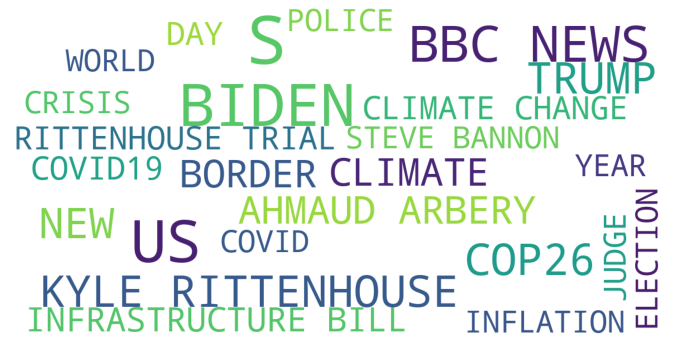

In [6]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [7]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
keywords = {
    'biden':['biden'],
    'trump':['trump'],
    'rittenhouse':['rittenhouse'],
    'climate':['cop26','cop 26','climate'],
    'border':['border'],
    'economy':['inflation','infrastructure'],
    'covid':['covid','covid19','covid-19'],
    'arbery':['arbery'],
    'bannon':['bannon'],
    'usa':['us','u.s','usa','u.s.a']
}

# Create Indicator variables
for topic in keywords:
    words = keywords[topic]
    df[topic] = np.where(df['title'].str.contains('|'.join(words)), 1, 0)

Video title sentiment

In [8]:
clf = SentimentIntensityAnalyzer()
df['titleSentiment'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])

Translate `duration` to seconds.

In [9]:
# PT format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# Convert seconds to log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Sort data by upload date

In [10]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [11]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

Declare time (seconds) until treatment and interaction

In [12]:
# Seconds until treatment
df['sut'] = (pd.Timestamp('2021-11-10') - df['publishedAt']).dt.total_seconds()

# Interaction
df['treatSut'] = df['sut'].multiply(df['treat'])

## 3. EDA
List of targets

### 3.1. Descriptive statistics
Number of available videos as a function of $h$

In [13]:
# Columns to use
cols = ['post'+str(i * 12)+'CommentsNum' for i in range(1,7)]

# Merge to get videoId & posthCommentsNum
t = pd.merge(d1[['videoId','publishedAt']], d2[['videoId'] + cols], on='videoId', how='outer')

# Create C&T groups
t['treat'] = np.where(t['publishedAt'] > '2021-11-10', 1, 0)

# Count available videos per window
t[cols] = t[cols].notna().astype(int)

# Group by
t = t.groupby('treat').agg({**{'videoId':'size'}, **dict(zip(cols,['sum']*6))}).transpose()

# Format
t.index = ['Total videos'] + ['h = ' + str(i*12) for i in range(1,7)]

# To latex
print(t.to_latex(caption='Number of available videos for different values of $h$',
                 label='tab_dat_nobs'))

\begin{table}
\centering
\caption{Number of available videos for different values of $h$}
\label{tab_dat_nobs}
\begin{tabular}{lrr}
\toprule
treat &    0 &    1 \\
\midrule
Total videos &  831 &  899 \\
h = 12       &  678 &  855 \\
h = 24       &  583 &  855 \\
h = 36       &  463 &  855 \\
h = 48       &  428 &  855 \\
h = 60       &  344 &  855 \\
h = 72       &  319 &  855 \\
\bottomrule
\end{tabular}
\end{table}



Balance table (conditional on 12$h$)

In [14]:
# Order dummy variables by frequency
X = ['biden','trump','rittenhouse','climate','border','economy','covid','arbery','bannon','usa']
X = df[X].mean().sort_values(ascending=False).index.tolist()

# Add remaining covariates
X = ['titleSentiment','seconds','definition'] + X

# Means by group
t = df.groupby('treat')[X].mean().transpose()

# Calculate p-values of differences
pvals = []
for x in X:
    p = ttest_ind(df.loc[df['treat'].eq(1), x], df.loc[df['treat'].eq(0), x])
    pvals.append(p[1])
t['p'] = pvals

# Change column names
t.columns = ['Control','Treatment','p-value']

# To latex
print(t.to_latex(caption='Balance table for videos with comments posted within first 12 hours ('+str(len(df)) + ')',
                 label='tab_dat_balance', float_format='%.3f'))

\begin{table}
\centering
\caption{Balance table for videos with comments posted within first 12 hours (1533)}
\label{tab_dat_balance}
\begin{tabular}{lrrr}
\toprule
{} &  Control &  Treatment &  p-value \\
\midrule
titleSentiment &   -0.066 &     -0.087 &    0.249 \\
seconds        &  595.288 &    642.011 &    0.642 \\
definition     &    0.872 &      0.864 &    0.673 \\
usa            &    0.258 &      0.283 &    0.276 \\
climate        &    0.062 &      0.069 &    0.580 \\
biden          &    0.063 &      0.064 &    0.943 \\
economy        &    0.038 &      0.053 &    0.187 \\
covid          &    0.044 &      0.039 &    0.580 \\
rittenhouse    &    0.010 &      0.063 &    0.000 \\
trump          &    0.024 &      0.042 &    0.047 \\
border         &    0.022 &      0.030 &    0.318 \\
bannon         &    0.001 &      0.037 &    0.000 \\
arbery         &    0.027 &      0.014 &    0.079 \\
\bottomrule
\end{tabular}
\end{table}



### 3.2. Visualizations

In [15]:
windows = ['Post' + str(h * 12) for h in range(1,7)]

Plot time series

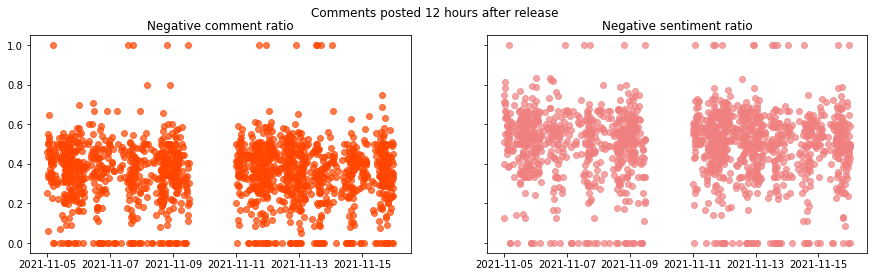

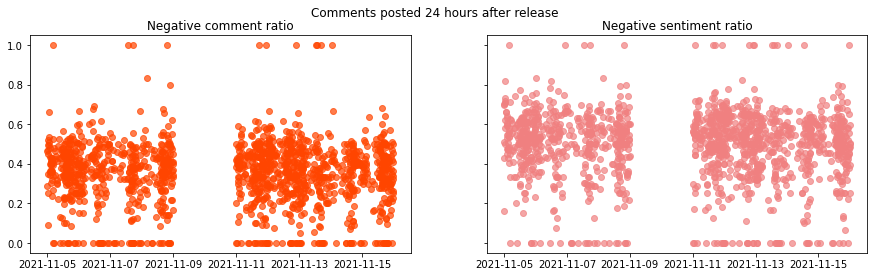

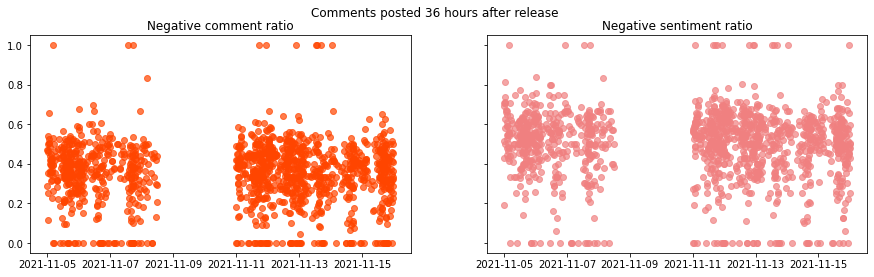

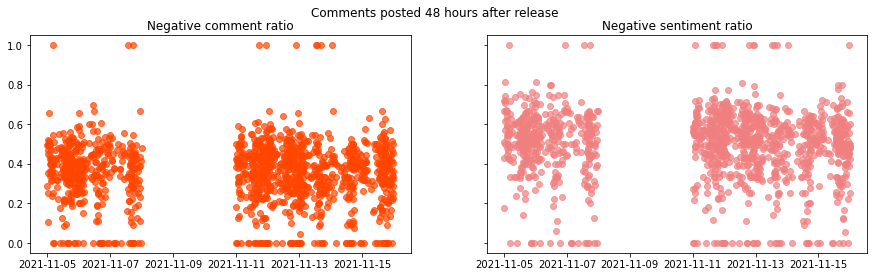

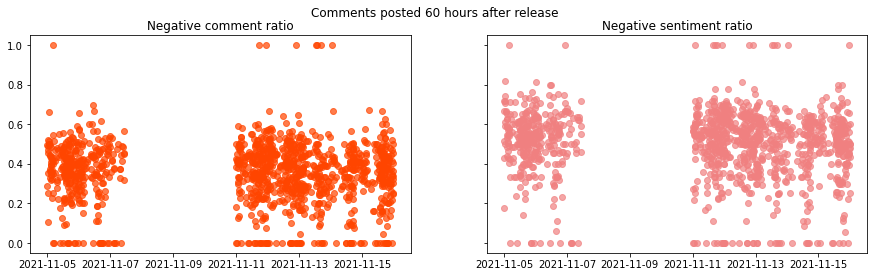

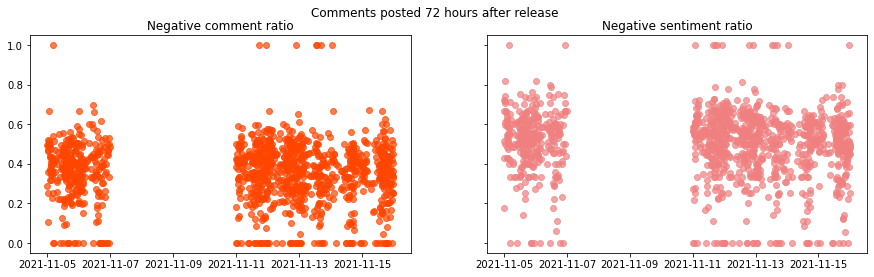

In [16]:
for window in windows:
    t = df.loc[df[window.lower() + 'CommentsNum'] > 0, ['publishedAt','ncr1'+window,'ncr2'+window]]
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.suptitle('Comments posted ' + window[-2:] + ' hours after release')
    ax[0].set_title('Negative comment ratio')
    ax[0].scatter(t['publishedAt'], t['ncr1'+window], color='orangered', alpha=0.7)
    ax[1].set_title('Negative sentiment ratio')
    ax[1].scatter(t['publishedAt'], t['ncr2'+window], color='lightcoral', alpha=0.7)
    plt.show()

## 4. Regression Analysis

### 4.1. No running variable

In [17]:
# Add constant
df['const'] = 1

# List of independent variables
X = ['treat','const','logSeconds','titleSentiment','definition','biden','trump',
     'rittenhouse','climate','border','economy','covid','arbery','bannon']

# For each
for target in ['ncr1','ncr2']:
    for window in windows:
        # State case
        print(target + window)
        # First OLS model
        m0 = sm.OLS(endog=df[target + window], exog=df[X], missing='drop')
        m0_fit = m0.fit(cov_type='HC0')
        p = m0_fit.pvalues
        print(m0_fit.summary().tables[1])

        # Backwards stepwise selection
        while any(p > 0.1):
            p = m0_fit.pvalues.drop(['const','treat'])
            p = p[p > 0.1]
            if len(p) > 0:
                X.remove(p.idxmax())
                m0 = sm.OLS(endog=df[target + window], exog=df[X], missing='drop')
                m0_fit = m0.fit(cov_type='HC0')
                print('\nDropped ', p.idxmax())
                print(m0_fit.summary().tables[1])
        print('\n\n')

ncr1Post12
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
treat             -0.0142      0.008     -1.775      0.076      -0.030       0.001
const              0.1387      0.027      5.095      0.000       0.085       0.192
logSeconds         0.0219      0.003      6.413      0.000       0.015       0.029
titleSentiment    -0.0941      0.011     -8.559      0.000      -0.116      -0.073
definition         0.0768      0.020      3.824      0.000       0.037       0.116
biden              0.0164      0.010      1.565      0.118      -0.004       0.037
trump              0.0771      0.012      6.271      0.000       0.053       0.101
rittenhouse        0.1390      0.013     10.364      0.000       0.113       0.165
climate            0.0207      0.018      1.177      0.239      -0.014       0.055
border             0.0087      0.020      0.439      0.660      -0.030      

### 4.1. Linear f
$NCR_i = \beta_0 + \beta_1 T_i + \beta_2 R_i + \beta_3 T_i \times R_i + \beta_4 Sentiment_i + u_i$

In [20]:
X = ['treat','sut','treatSut','const']
m1 = sm.OLS(endog=df['ncr1Post12'], exog=df[X], missing='drop')
m1_fit = m1.fit(cov_type='HC0')
m1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ncr1Post12   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.007
Date:                Tue, 29 Mar 2022   Prob (F-statistic):              0.111
Time:                        22:50:37   Log-Likelihood:                 602.75
No. Observations:                1533   AIC:                            -1198.
Df Residuals:                    1529   BIC:                            -1176.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treat          0.0363      0.019      1.911      0.056      -0.001       0.073
sut         8.943e-08   4.96e-08      1.801      0.072   -7.87e-09    1.87e-07
treatSut   -2.612e-08   6.38e-08     -0.409      0.682   -1.51e-07     9.9e-08
const          0.3235      0.014     23.106      0.000       0.296       0.351
==============================================================================
Omnibus:                       57.002   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.415
Skew:                          -0.099   Prob(JB):                     8.01e-34
Kurtosis:                       4.532   Cond. No.                     1.90e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.9e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""